In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unrar x /content/gdrive/MyDrive/'Colab Notebooks'/PH2Dataset.rar

In [3]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1kMEFRbutyHAxqQpFaoh-LIIjMwtk9KV-',
                                    dest_path='./PH2Dataset.rar',
                                    unzip=True)

Unzipping...

/usr/local/lib/python3.7/dist-packages/google_drive_downloader/google_drive_downloader.py:78: UserWarning: Ignoring `unzip` since "1kMEFRbutyHAxqQpFaoh-LIIjMwtk9KV-" does not look like a valid zip file
  warnings.warn('Ignoring `unzip` since "{}" does not look like a valid zip file'.format(file_id))


Датасет лежит тут [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

In [4]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [5]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [6]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


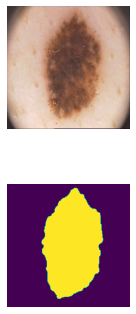

In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(1):
    plt.subplot(2, 7, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 7, i+8)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

In [9]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

print(len(tr), len(val), len(ts))

In [11]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [12]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)

cuda


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [14]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.enc_conv0 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),

                                       nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU())
        
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 256 -> 128
        
        self.enc_conv1 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),

                                       nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU())
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64
        
        self.enc_conv2 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),
                                       
                                       nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),
                                       
                                       nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU())
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32
        
        self.enc_conv3 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(),
                                       
                                       nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(),
                                       
                                       nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU())
        
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        self.enc_conv4 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(),
                                       
                                       nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(),
                                       
                                       nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU())
      
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        


        self.upsample0 =  nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(),
                                       
                                       nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(),
                                       
                                       nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU())
        
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(),
                                       
                                       nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(),
                                       
                                       nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU())
        
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),
                                       
                                       nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),
                                       
                                       nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU())
        
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),
                                       
                                       nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU())
        
        self.upsample4 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 128 -> 256
        self.dec_conv4 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),
                                       nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1))
        
    def forward(self, x):
        # encoder
        e0, id0 = self.pool0(self.enc_conv0(x))
        e1, id1 = self.pool1(self.enc_conv1(e0))
        e2, id2 = self.pool2(self.enc_conv2(e1))
        e3, id3 = self.pool3(self.enc_conv3(e2))
        e4, id4 = self.pool4(self.enc_conv4(e3))
        
        
        # decoder
        d0 = self.dec_conv0(self.upsample0(e4, id4))
        d1 = self.dec_conv1(self.upsample1(d0, id3))
        d2 = self.dec_conv2(self.upsample2(d1, id2))
        d3 = self.dec_conv3(self.upsample3(d2, id1))
        d4 = self.dec_conv4(self.upsample4(d3, id0))
        return d4

Ниже определена метрика

In [15]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    SMOOTH = 1e-8
    intersection = (outputs.type(torch.int).to(device) & labels.type(torch.int).to(device)).float().sum((1, 2))
    union = (outputs.type(torch.int).to(device) | labels.type(torch.int).to(device) ).float().sum((1, 2))

    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10
    
    return thresholded

Используем bce_loss

In [16]:
def bce_loss(y_real, y_pred):
    return (y_pred - y_pred * y_real + torch.log(1.0 + torch.exp(-y_pred))).mean()

In [17]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    history = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            opt.zero_grad()
            
            Y_pred = predict(model, X_batch, 'train')
            
            loss = loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()
            avg_loss += loss / len(data_tr)
        
        toc = time()
        print('loss: %f' % avg_loss)

        model.eval()
        Y_hat = predict(model, X_val.to(device), 'eval').detach().cpu()
        
        val_loss = loss_fn(Y_val, Y_hat) / len(data_val)
        history.append((avg_loss, val_loss))

        clear_output(wait=True)
        for k in range(5):
            plt.subplot(2, 10, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 10, k+11)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    return history

In [18]:
def predict(model, X_batch, mod):
  if mod == 'train':     
    model.train()
    Y_pred = model(X_batch.to(device))
  else:
    model.eval()
    Y_pred = model(X_batch.to(device))
    Y_pred = (((torch.sigmoid(Y_pred)) > 0.7).type(torch.FloatTensor)).to(device)
  return Y_pred

In [19]:
def score_model(model, metric, data):
    scores = 0
    for X_batch, Y_label in data:
      with torch.no_grad():
        Y_pred = predict(model, X_batch, 'eval')
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

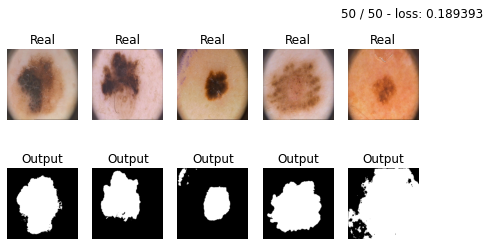

In [28]:
model_bce_loss = SegNet().to(device)
max_epochs = 50

optim = torch.optim.AdamW(model_bce_loss.parameters(), lr = 0.001)
torch.optim.lr_scheduler.StepLR(optim, gamma=0.1, step_size=10)
his = train(model_bce_loss, optim, bce_loss, max_epochs, data_tr, data_val)

In [29]:
score_model(model_bce_loss, iou_pytorch, data_val)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.6850546956062317

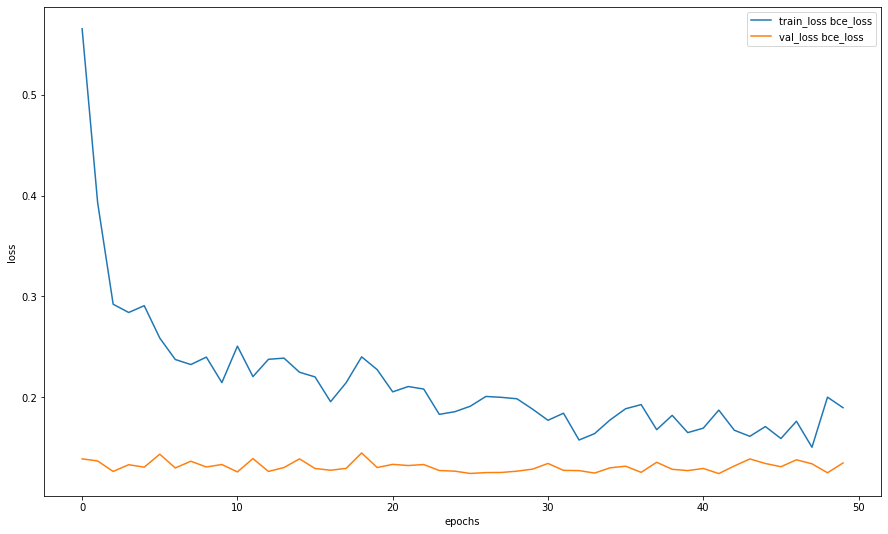

In [30]:
loss, val_loss = zip(*his)
plt.figure(figsize=(15, 9))
plt.plot([loss[i].detach().cpu().numpy() for i in range(len(loss))], label="train_loss" + ' ' + bce_loss.__name__)
plt.plot([val_loss[i].detach().cpu().numpy() for i in range(len(val_loss))], label="val_loss" + ' ' + bce_loss.__name__)
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Так же были добавлены ещё два loss

In [20]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    num = 1/(256*256)
    y_pred = torch.sigmoid(y_pred)

    y_pred = y_pred.view(-1)
    y_true = y_true.view(-1)

    intersection = (y_pred * y_true).sum()
    
    return 1 - ((2. * intersection + smooth) / (y_pred.sum() + y_true.sum() + smooth))

In [21]:
def focal_loss(y_real, y_pred, eps = 1e-8, alfa = 1, gamma = 2):
    
    y_pred = torch.sigmoid(y_pred)
    your_loss = -alfa * y_real * torch.pow(1 - y_pred, gamma) * torch.log(y_pred) - (1 - y_real) * y_pred * torch.log(1 - y_pred)

    return your_loss.mean()


Описали модель UNet c MaxUnpool2d

In [22]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
                                       nn.ReLU(),

                                       nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                       nn.ReLU())
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 256 -> 128

        self.enc_conv1 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                                       nn.ReLU(),

                                       nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                       nn.ReLU())
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                                       nn.ReLU(),

                                       nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                       nn.ReLU())
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                                       nn.ReLU(),

                                       nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.ReLU())
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
                                       nn.ReLU(),

                                       nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
                                       nn.ReLU())

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
                                       nn.ReLU(),

                                       nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
                                       nn.ReLU())
        
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
                                       nn.ReLU(),

                                       nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
                                       nn.ReLU())
        
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
                                       nn.ReLU(),

                                       nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
                                       nn.ReLU())
        
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
                                       nn.ReLU(),

                                       nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       
                                       nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, padding=0))

    def forward(self, x):
        # encoder
        g0 = self.enc_conv0(x)
        e0, id0 = self.pool0(g0)
        
        g1 = self.enc_conv1(e0)
        e1, id1 = self.pool1(g1)
        
        g2 = self.enc_conv2(e1)
        e2, id2 = self.pool2(g2)

        g3 = self.enc_conv3(e2)
        e3, id3 = self.pool3(g3)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(torch.cat([g3, self.upsample0(b, id3)], dim=1))
        d1 = self.dec_conv1(torch.cat([g2, self.upsample0(d0, id2)], dim=1))
        d2 = self.dec_conv2(torch.cat([g1, self.upsample0(d1, id1)], dim=1))
        d3 = self.dec_conv3(torch.cat([g0, self.upsample0(d2, id0)], dim=1)) # no activation

        return d3

Описали модель UNet c ConvTranspose2d

In [23]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
                                       nn.ReLU(),

                                       nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                       nn.ReLU())
        self.poolConv0 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=2) # 256 -> 128

        self.enc_conv1 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                                       nn.ReLU(),

                                       nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                       nn.ReLU())
        self.poolConv1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, stride=2) # 128 -> 64

        self.enc_conv2 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                                       nn.ReLU(),

                                       nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                       nn.ReLU())
        self.poolConv2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=2) # 64 -> 32

        self.enc_conv3 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                                       nn.ReLU(),

                                       nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.ReLU())
        self.poolConv3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
                                       nn.ReLU(),

                                       nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
                                       nn.ReLU())

        # decoder (upsampling)
        self.ConvTrans0 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
                                       nn.ReLU(),

                                       nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
                                       nn.ReLU())
        
        self.ConvTrans1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
                                       nn.ReLU(),

                                       nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
                                       nn.ReLU())
        
        self.ConvTrans2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
                                       nn.ReLU(),

                                       nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
                                       nn.ReLU())
        
        self.ConvTrans3 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
                                       nn.ReLU(),

                                       nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                       nn.ReLU(),
                                       
                                       nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, padding=0))

    def forward(self, x):
        # encoder
        g0 = self.enc_conv0(x)
        e0 = self.poolConv0(g0)
        
        g1 = self.enc_conv1(e0)
        e1 = self.poolConv1(g1)
        
        g2 = self.enc_conv2(e1)
        e2 = self.poolConv2(g2)

        g3 = self.enc_conv3(e2)
        e3 = self.poolConv3(g3)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(torch.cat([g3, self.ConvTrans0(b)], dim=1))
        d1 = self.dec_conv1(torch.cat([g2, self.ConvTrans1(d0)], dim=1))
        d2 = self.dec_conv2(torch.cat([g1, self.ConvTrans2(d1)], dim=1))
        d3 = self.dec_conv3(torch.cat([g0, self.ConvTrans3(d2)], dim=1)) # no activation

        return d3

Определим модель SegNet с разными loss, обучим и посмотрим на скор на валидационной выборке. Так же посмотрим на график падения loss.



In [ ]:
model_dice = SegNet().to(device)
model_focal = SegNet().to(device)
model_bce = SegNet().to(device)
max_epochs = 50

model = [[model_dice, dice_loss], [model_focal, focal_loss], [model_bce, bce_loss]]

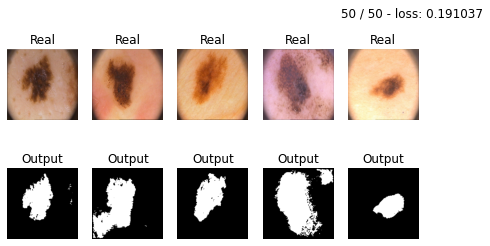

In [ ]:
history = []
for i in model:
  optim = torch.optim.AdamW(i[0].parameters(), lr = 0.001)
  torch.optim.lr_scheduler.StepLR(optim, gamma=0.1, step_size=10)
  history.append(train(i[0], optim, i[1], max_epochs, data_tr, data_val))

Как видно скор почти одинаковый, но у focal_loss всё же немного больше

In [ ]:
for i in model:
  print(score_model(i[0], iou_pytorch, data_val), i[1].__name__)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.7278125286102295 dice_loss
0.7309609532356263 focal_loss
0.7278906583786011 bce_loss


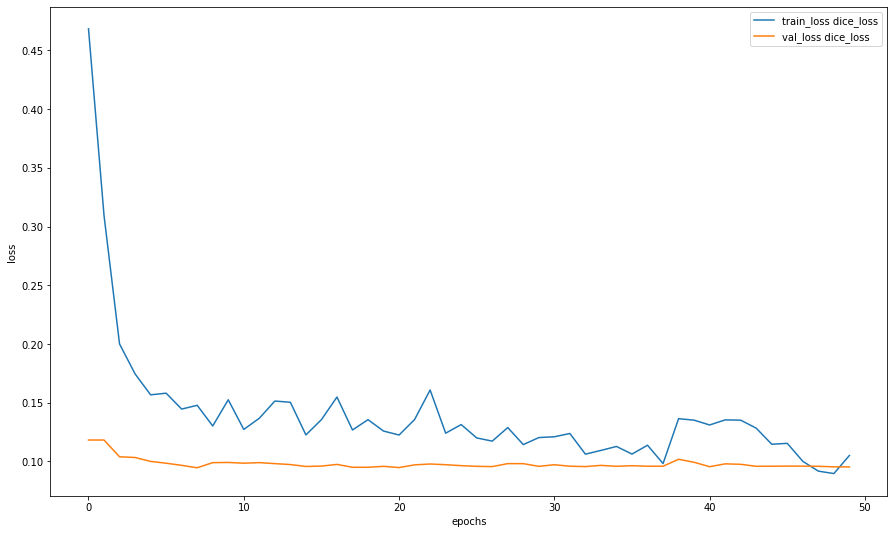

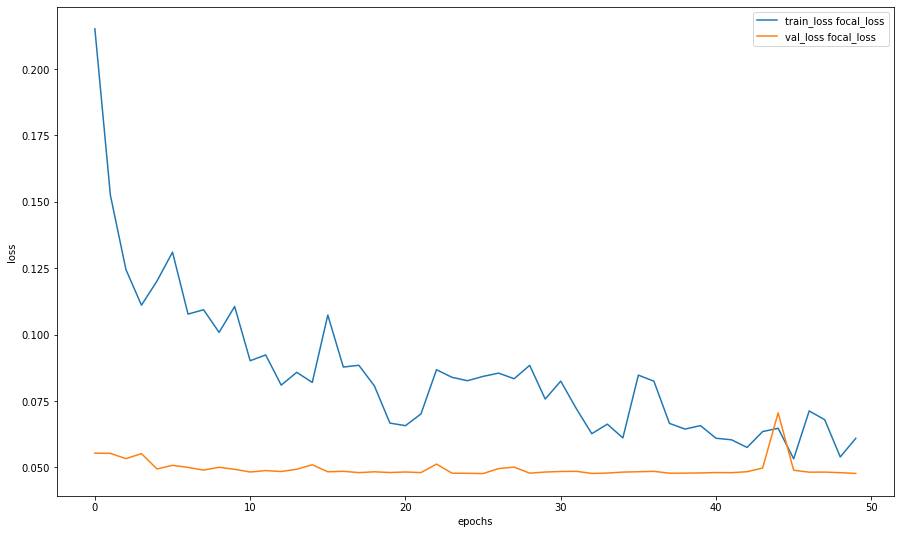

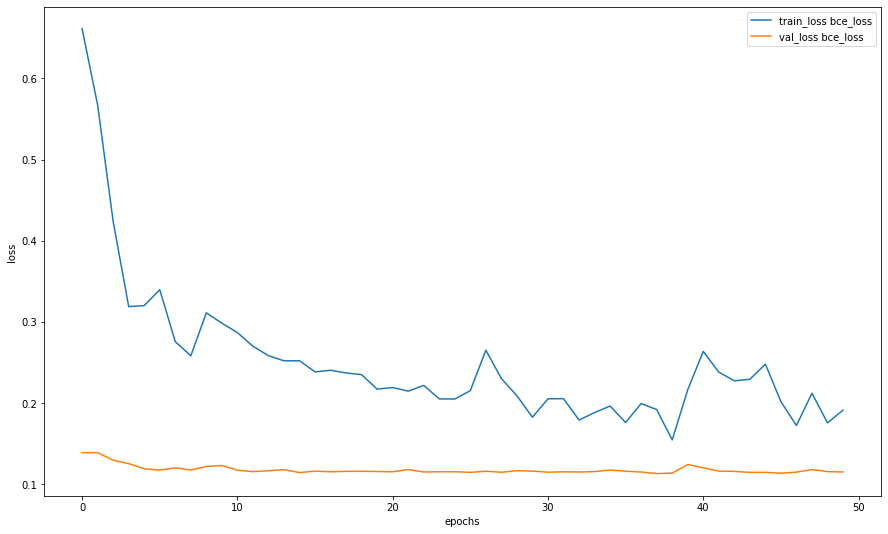

In [ ]:
for i in range(3):
  loss, val_loss = zip(*(history[i]))
  plt.figure(figsize=(15, 9))
  plt.plot([loss[i].detach().cpu().numpy() for i in range(len(loss))], label="train_loss" + ' ' + model[i][1].__name__)
  plt.plot([val_loss[i].detach().cpu().numpy() for i in range(len(val_loss))], label="val_loss" + ' ' + model[i][1].__name__)
  plt.legend(loc='best')
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.show()

Определим модель Unet с разными loss, обучим и посмотрим на скор на валидационной выборке. Так же посмотрим на график падения loss.

In [ ]:
unet_model_dice_loss = UNet().to(device)
unet_model_focal_loss = UNet().to(device)
unet_model_bce_loss = UNet().to(device)
max_epochs = 50
unet_model = [[unet_model_dice_loss, dice_loss], [unet_model_focal_loss, focal_loss], [unet_model_bce_loss, bce_loss]]

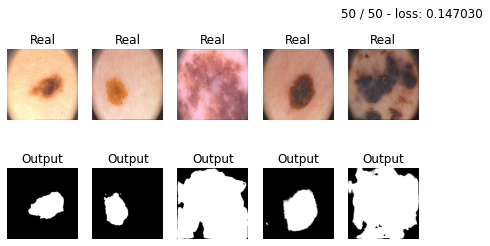

In [ ]:
unet_history = []
for i in unet_model:
  optim = torch.optim.AdamW(i[0].parameters(), lr = 0.001)
  torch.optim.lr_scheduler.StepLR(optim, gamma=0.1, step_size=10)
  unet_history.append(train(i[0], optim, i[1], max_epochs, data_tr, data_val))

Как можно заметить лучще всего работает Unet c bce_loss.

In [ ]:
for i in unet_model:
  print(score_model(i[0], iou_pytorch, data_val), i[1].__name__)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


0.21321095377206803 dice_loss
0.6252968907356262 focal_loss
0.7461641073226929 bce_loss


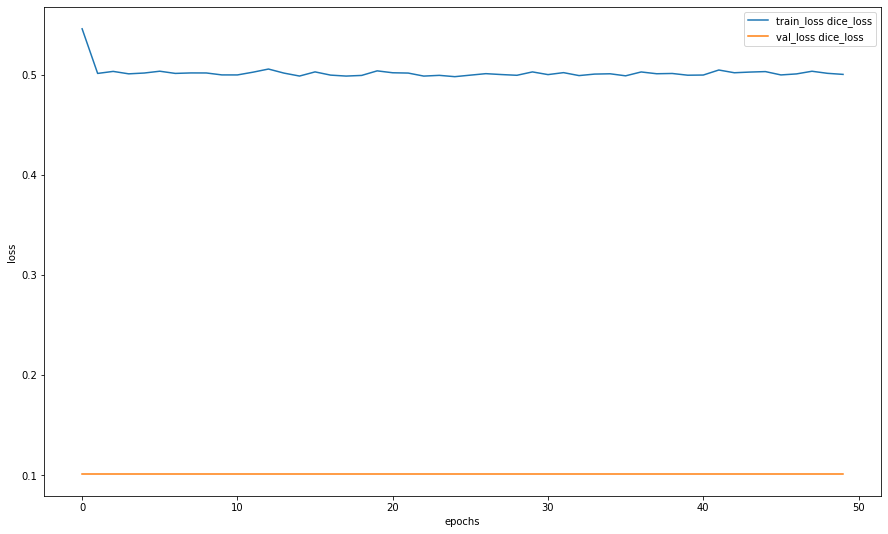

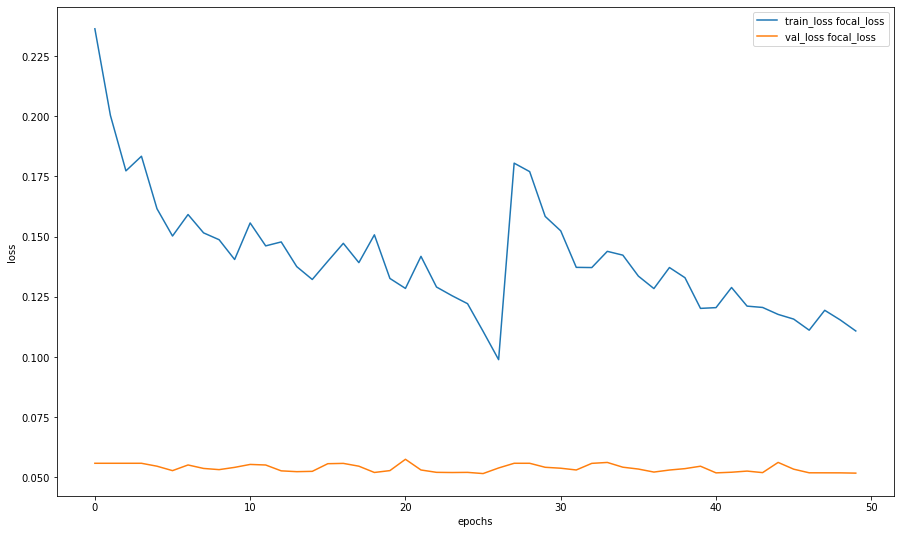

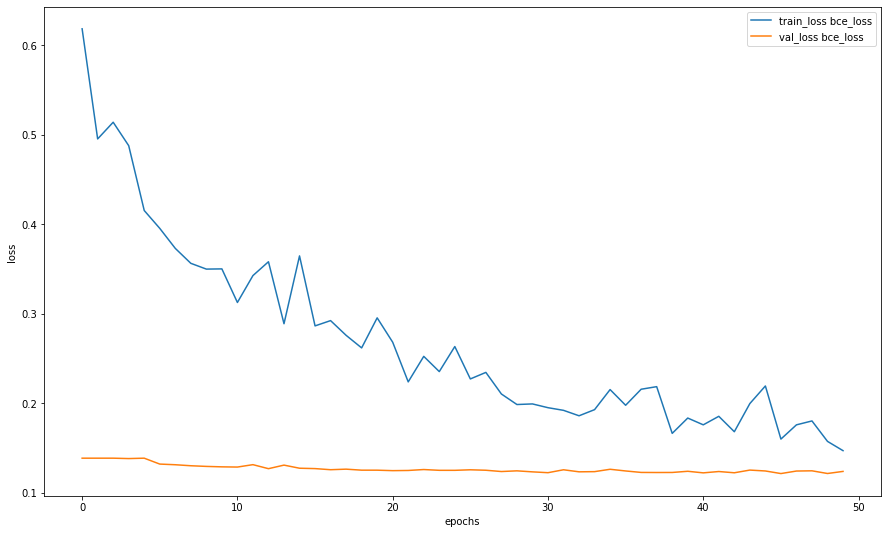

In [ ]:
for i in range(3):
  loss, val_loss = zip(*(unet_history[i]))
  plt.figure(figsize=(15, 9))
  plt.plot([loss[i].detach().cpu().numpy() for i in range(len(loss))], label="train_loss" + ' ' + unet_model[i][1].__name__)
  plt.plot([val_loss[i].detach().cpu().numpy() for i in range(len(val_loss))], label="val_loss" + ' ' + unet_model[i][1].__name__)
  plt.legend(loc='best')
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.show()

Определим модель Unet2 с разными loss, обучим и посмотрим на скор на валидационной выборке. Так же посмотрим на график падения loss.

In [ ]:
unet2_model_dice_loss = UNet2().to(device)
unet2_model_focal_loss = UNet2().to(device)
unet2_model_bce_loss = UNet2().to(device)
max_epochs = 50

unet2_model = [[unet2_model_dice_loss, dice_loss], [unet2_model_focal_loss, focal_loss], [unet2_model_bce_loss, bce_loss]]

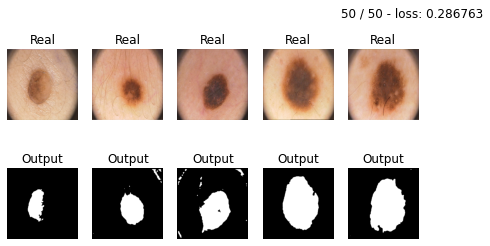

In [ ]:
unet2_history = []
for i in unet2_model:
  optim = torch.optim.AdamW(i[0].parameters(), lr = 0.001)
  torch.optim.lr_scheduler.StepLR(optim, gamma=0.1, step_size=10)
  unet2_history.append(train(i[0], optim, i[1], max_epochs, data_tr, data_val))

Как видно Unet2 одинаков при focal_loss и bce_loss. Есои судить по графикам, то стоит ещё какое-то время пообучать модели.

In [ ]:
for i in unet2_model:
  print(score_model(i[0], iou_pytorch, data_val), i[1].__name__)

0.21321093887090684 dice_loss
0.6031875073909759 focal_loss
0.605929720401764 bce_loss


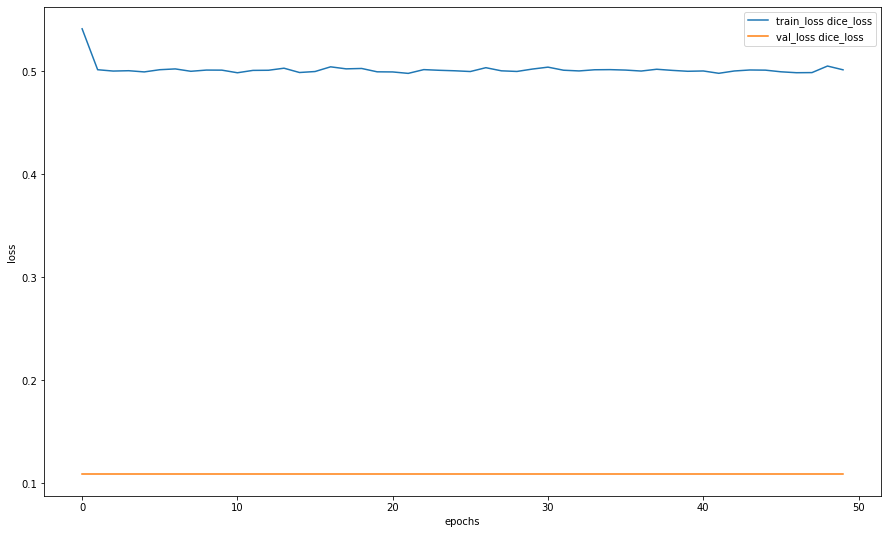

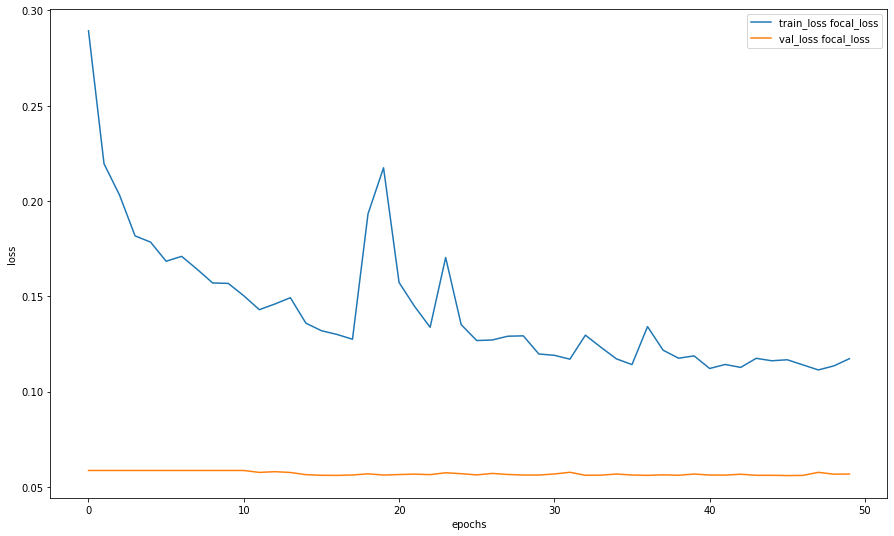

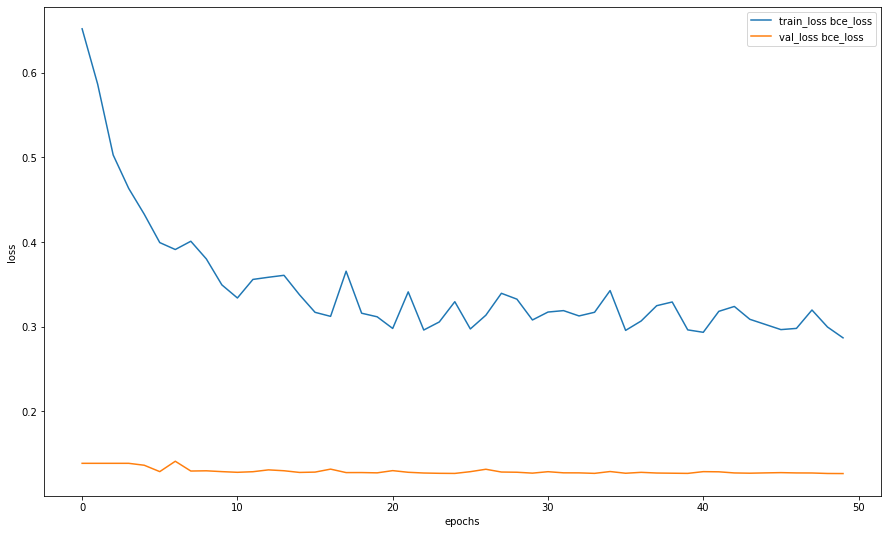

In [ ]:
for i in range(3):
  loss, val_loss = zip(*(unet2_history[i]))
  plt.figure(figsize=(15, 9))
  plt.plot([loss[i].detach().cpu().numpy() for i in range(len(loss))], label="train_loss" + ' ' + unet2_model[i][1].__name__)
  plt.plot([val_loss[i].detach().cpu().numpy() for i in range(len(val_loss))], label="val_loss" + ' ' + unet2_model[i][1].__name__)
  plt.legend(loc='best')
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.show()

Лучшими оказались SegNet c focal_loss и UNet c bce_loss.